In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pandas as pd
import tensorflow as tf
import matplotlib as plt
import sklearn as skl
from sklearn.datasets import make_circles

In [2]:
url = 'https://raw.githubusercontent.com/mward95/project_4/main/data/Copy_of_myopia.csv'
myopia_df = pd.read_csv(url)
myopia_df.head()

,ID,STUDYYEAR,MYOPIC,AGE,GENDER,SPHEQ,AL,ACD,LT,VCD,SPORTHR,READHR,COMPHR,STUDYHR,TVHR,DIOPTERHR,MOMMY,DADMY
0,1,1992,1,6,1,-0.052,21.89,3.690,3.498,14.70,45,8,0,0,10,34,1,1
1,2,1995,0,6,1,0.608,22.38,3.702,3.392,15.29,4,0,1,1,7,12,1,1
2,3,1991,0,6,1,1.179,22.49,3.462,3.514,15.52,14,0,2,0,10,14,0,0
3,4,1990,1,6,1,0.525,22.20,3.862,3.612,14.73,18,11,0,0,4,37,0,1
4,5,1995,0,5,0,0.697,23.29,3.676,3.454,16.16,14,0,0,0,4,4,1,0


In [3]:
# Remove MYOPIC target from features data
y = myopia_df.MYOPIC.values
X = myopia_df.drop(columns="MYOPIC").values

# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [4]:
# Preprocess numerical data for neural network

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [5]:
# Define the deep learning model 
nn_model = tf.keras.models.Sequential()
nn_model.add(tf.keras.layers.Dense(units=16, activation="relu", input_dim=17))
nn_model.add(tf.keras.layers.Dense(units=16, activation="relu"))
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                288       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Compile the Sequential model together and customize metrics
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


In [7]:
# Train the model
fit_model = nn_model.fit(X_train_scaled,y_train,epochs=100)

Epoch 1/100
15/15 [==============================] - 1s 2ms/step - loss: 0.7141 - accuracy: 0.5378
Epoch 2/100
15/15 [==============================] - 0s 2ms/step - loss: 0.5855 - accuracy: 0.7171
Epoch 3/100
15/15 [==============================] - 0s 2ms/step - loss: 0.5082 - accuracy: 0.8229
Epoch 4/100
15/15 [==============================] - 0s 2ms/step - loss: 0.4577 - accuracy: 0.8575
Epoch 5/100
15/15 [==============================] - 0s 2ms/step - loss: 0.4258 - accuracy: 0.8683
Epoch 6/100
15/15 [==============================] - 0s 2ms/step - loss: 0.4049 - accuracy: 0.8683
Epoch 7/100
15/15 [==============================] - 0s 2ms/step - loss: 0.3885 - accuracy: 0.8683
Epoch 8/100
15/15 [==============================] - 0s 2ms/step - loss: 0.3752 - accuracy: 0.8683
Epoch 9/100
15/15 [==============================] - 0s 2ms/step - loss: 0.3641 - accuracy: 0.8683
Epoch 10/100
15/15 [==============================] - 0s 2ms/step - loss: 0.3535 - accuracy: 0.8683
Epoch 11/

In [8]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

5/5 - 0s - loss: 0.5999 - accuracy: 0.8387 - 146ms/epoch - 29ms/step
Loss: 0.5998532772064209, Accuracy: 0.8387096524238586


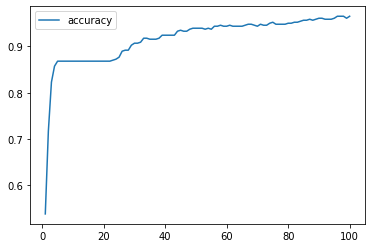

In [9]:
# Create a DataFrame containing training history
# history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))
history_df = pd.DataFrame(fit_model.history)
history_df.index += 1
# Plot the accuracy
history_df.plot(y="accuracy")

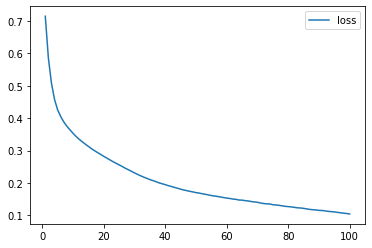

In [10]:
history_df.plot(y="loss")

In [11]:
history_df

,loss,accuracy
1,0.714054,0.537797
2,0.585541,0.717063
3,0.508156,0.822894
4,0.457746,0.857451
5,0.425837,0.868251
...,...,...
96,0.109399,0.965443
97,0.108220,0.965443
98,0.106905,0.965443
99,0.105956,0.961123


In [12]:
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=10,
        step=2), activation=activation, input_dim=17))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 6)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=10,
            step=2),
            activation=activation))
    
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

In [14]:
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 7.5 MB/s 
     |████████████████████████████████| 1.6 MB 53.9 MB/s 


In [15]:
# Import the kerastuner library
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=80,
    hyperband_iterations=2)

In [21]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=80,validation_data=(X_test_scaled,y_test))

Trial 218 Complete [00h 00m 11s]
val_accuracy: 0.8709677457809448

Best val_accuracy So Far: 0.896774172782898
Total elapsed time: 01h 17m 10s


In [22]:
# Get top 3 model hyperparameters and print the values
top_hyper = tuner.get_best_hyperparameters(3)
for param in top_hyper:
    print(param.values)

{'activation': 'tanh', 'first_units': 9, 'num_layers': 3, 'units_0': 5, 'units_1': 9, 'units_2': 5, 'units_3': 3, 'units_4': 3, 'units_5': 7, 'tuner/epochs': 80, 'tuner/initial_epoch': 27, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0157'}
{'activation': 'tanh', 'first_units': 1, 'num_layers': 1, 'units_0': 9, 'units_1': 7, 'units_2': 3, 'units_3': 7, 'units_4': 5, 'units_5': 3, 'tuner/epochs': 80, 'tuner/initial_epoch': 27, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0165'}
{'activation': 'tanh', 'first_units': 3, 'num_layers': 4, 'units_0': 3, 'units_1': 7, 'units_2': 5, 'units_3': 3, 'units_4': 3, 'units_5': 5, 'tuner/epochs': 27, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}


In [23]:
# Evaluate the top 3 models against the test dataset
top_model = tuner.get_best_models(3)
for model in top_model:
    model_loss, model_accuracy = model.evaluate(X_test_scaled,y_test,verbose=2)
    print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

5/5 - 0s - loss: 0.3602 - accuracy: 0.8968 - 226ms/epoch - 45ms/step
Loss: 0.3602321147918701, Accuracy: 0.896774172782898
5/5 - 0s - loss: 0.3325 - accuracy: 0.8903 - 275ms/epoch - 55ms/step
Loss: 0.3325483798980713, Accuracy: 0.8903225660324097
5/5 - 1s - loss: 0.3439 - accuracy: 0.8839 - 540ms/epoch - 108ms/step
Loss: 0.34385085105895996, Accuracy: 0.8838709592819214


In [24]:
# Get second best model hyperparameters
second_hyper = tuner.get_best_hyperparameters(2)[1]
second_hyper.values

{'activation': 'tanh',
 'first_units': 1,
 'num_layers': 1,
 'units_0': 9,
 'units_1': 7,
 'units_2': 3,
 'units_3': 7,
 'units_4': 5,
 'units_5': 3,
 'tuner/epochs': 80,
 'tuner/initial_epoch': 27,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0165'}

In [25]:
# Compare the performance to the second-best model
second_model = tuner.get_best_models(2)[1]
model_loss, model_accuracy = second_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

5/5 - 0s - loss: 0.3325 - accuracy: 0.8903 - 198ms/epoch - 40ms/step
Loss: 0.3325483798980713, Accuracy: 0.8903225660324097
